# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_Aging2_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for Aging2 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_Aging2_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [1]:
library(data.table)
library(tidyverse)
library(pecotmr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
setwd("~/data")

In [3]:
##Bonfferroni correction is too strict
# Aging2_twas = fread("~/project/image_QTL/twas/multiple_testing/image_Aging2_twas_bonff.bonf_corrected.tsv.gz")


In [4]:
Aging2_twas = fread("~/project/image_QTL/twas/image_Aging2_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [8]:
# weight_db_list = fread("~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv")


In [9]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- Aging2_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [10]:
head(Aging2_twas)
dim(Aging2_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,enet,TRUE,FALSE,0.098757440,8.923911e-10,0.4422873,0.65828134,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,lasso,TRUE,FALSE,0.103370596,3.541036e-10,0.5153586,0.60630249,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,mrash,TRUE,FALSE,0.089177838,6.013310e-09,0.3763701,0.70664179,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging2,susie,TRUE,TRUE,0.121638427,8.766557e-12,0.4166957,0.67690100,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging2,enet,TRUE,FALSE,0.007872702,5.201216e-02,2.3533373,0.01860575,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging2,lasso,TRUE,FALSE,0.006195072,7.447581e-02,2.2734046,0.02300181,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 920648     19

In [37]:
# Strong and reliable TWAS signals:
Aging2_twas_filtered <- Aging2_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
Aging2_block = unique(Aging2_twas_filtered$block)

In [38]:
dim(Aging2_twas_filtered)

[1] 1077   19

In [39]:
most_likely_causal_genes = Aging2_twas_filtered |> 
  group_by(context, region) |> 
  slice_max(abs(twas_z), n = 1)

In [40]:
head(most_likely_causal_genes)
dim(most_likely_causal_genes)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000258539,124791726,123617080,125840000,AC_DeJager_eQTL,image_Aging2,mvsusie,TRUE,TRUE,0.04231413,2.596192e-07,-7.451655,9.217655e-14,eQTL,chr10_123788803_125506866,chr10_123788803_125506866,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr10_123788803_125506866.twas.tsv.gz
10,ENSG00000095787,28532492,26880000,30640000,AC_DeJager_eQTL,image_Aging2,lasso,TRUE,FALSE,0.08548739,2.256029e-13,-4.845380,1.263695e-06,eQTL,chr10_28362609_29522130,chr10_28362609_29522130,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr10_28362609_29522130.twas.tsv.gz
12,ENSG00000135119,116738177,115738177,117853631,AC_DeJager_eQTL,image_Aging2,susie,TRUE,TRUE,0.02721615,3.204935e-05,-13.837025,1.523832e-43,eQTL,chr12_115165608_117668628,chr12_115165608_117668628,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr12_115165608_117668628.twas.tsv.gz
12,ENSG00000174106,65169582,64169582,66248355,AC_DeJager_eQTL,image_Aging2,enet,TRUE,FALSE,0.04249581,2.449929e-07,-6.592276,4.331337e-11,eQTL,chr12_61991992_65677087,chr12_61991992_65677087,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr12_61991992_65677087.twas.tsv.gz
16,ENSG00000169203,29505998,25040000,34000000,AC_DeJager_eQTL,image_Aging2,mrash,TRUE,FALSE,0.14495571,4.118059e-22,5.358868,8.374506e-08,eQTL,chr16_26796952_29685831,chr16_26796952_29685831,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr16_26796952_29685831.twas.tsv.gz
16,ENSG00000149932,29940884,28360000,34000000,AC_DeJager_eQTL,image_Aging2,mrash,TRUE,FALSE,0.05622454,3.023076e-09,-7.146940,8.873364e-13,eQTL,chr16_29685831_46381513,chr16_29685831_46381513,ROSMAP_eQTL_pQTL,ROSMAP_eQTL_pQTL.chr16_29685831_46381513.twas.tsv.gz


[1] 190  19

In [41]:
most_likely_causal_genes |> count(molecular_id) |> nrow()

[1] 190

In [42]:
Aging2_gene = unique(most_likely_causal_genes$molecular_id)

In [43]:
image_Aging2_gene_list <- Aging2_twas |> 
  dplyr::filter(molecular_id %in% Aging2_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), molecular_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, molecular_id) |> 
  unique()

In [44]:
dim(image_Aging2_gene_list)

[1] 69  4

In [45]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [46]:
image_Aging2_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_Aging2")) |> dplyr::select(-strand,-event_ID)
                                        

In [47]:
image_Aging2_gene = bind_rows(image_Aging2_gene_list, image_Aging2_QTL_gene)

In [48]:
fwrite(image_Aging2_gene, "~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging2_gene_list.tsv", sep = '\t')

### image_Aging2_QTL list

In [49]:

library(clusterProfiler)
library(org.Hs.eg.db)


In [50]:
image_Aging2_gene = fread("~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging2_gene_list.tsv")

In [51]:
Aging2_sig_gene_ego <- enrichGO(
  gene          = unique(image_Aging2_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [52]:
head(Aging2_sig_gene_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0090085,GO:0090085,regulation of protein deubiquitination,2/61,11/21261,0.0004379899,0.1489102,0.1306404,ENSG00000136560/ENSG00000145901,2
GO:0008630,GO:0008630,intrinsic apoptotic signaling pathway in response to DNA damage,4/61,126/21261,0.0004726352,0.1489102,0.1306404,ENSG00000143194/ENSG00000116062/ENSG00000103490/ENSG00000171552,4
GO:0071214,GO:0071214,cellular response to abiotic stimulus,6/61,351/21261,0.0005014931,0.1489102,0.1306404,ENSG00000102882/ENSG00000103490/ENSG00000006062/ENSG00000171552/ENSG00000136560/ENSG00000109320,6
GO:0104004,GO:0104004,cellular response to environmental stimulus,6/61,351/21261,0.0005014931,0.1489102,0.1306404,ENSG00000102882/ENSG00000103490/ENSG00000006062/ENSG00000171552/ENSG00000136560/ENSG00000109320,6
GO:0071347,GO:0071347,cellular response to interleukin-1,4/61,138/21261,0.0006656969,0.1489102,0.1306404,ENSG00000102882/ENSG00000103490/ENSG00000136560/ENSG00000109320,4
GO:0043124,GO:0043124,negative regulation of canonical NF-kappaB signal transduction,3/61,63/21261,0.0007894721,0.1489102,0.1306404,ENSG00000103490/ENSG00000136560/ENSG00000145901,3
GO:0060828,GO:0060828,regulation of canonical Wnt signaling pathway,5/61,270/21261,0.0010599961,0.1489102,0.1306404,ENSG00000110492/ENSG00000109320/ENSG00000205269/ENSG00000146374/ENSG00000171056,5
GO:0045862,GO:0045862,positive regulation of proteolysis,6/61,406/21261,0.0010697551,0.1489102,0.1306404,ENSG00000135119/ENSG00000174989/ENSG00000103490/ENSG00000136560/ENSG00000145901/ENSG00000171056,6
GO:0071222,GO:0071222,cellular response to lipopolysaccharide,5/61,274/21261,0.0011315818,0.1489102,0.1306404,ENSG00000102882/ENSG00000103490/ENSG00000175175/ENSG00000109320/ENSG00000145901,5


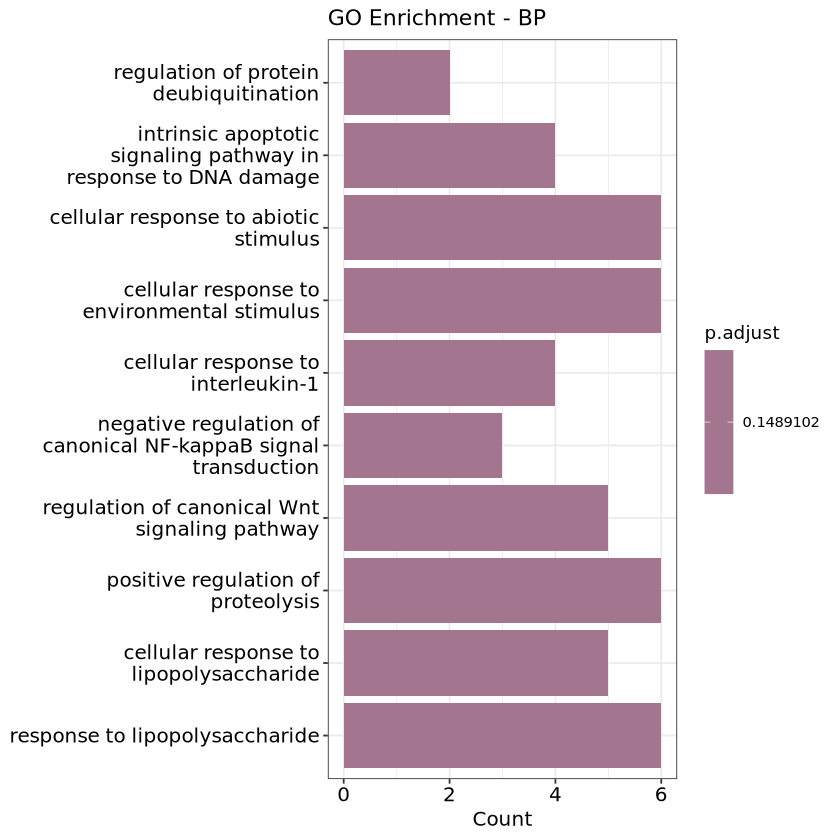

In [53]:
barplot(Aging2_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [54]:
Aging2_sig_gene_ego_cc <- enrichGO(
  gene          = unique(image_Aging2_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [55]:
head(Aging2_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016363,GO:0016363,nuclear matrix,3/66,134/22568,0.007131481,0.2447349,0.2076306,ENSG00000184575/ENSG00000159267/ENSG00000203760,3
GO:1902554,GO:1902554,serine/threonine protein kinase complex,3/66,154/22568,0.010417932,0.2447349,0.2076306,ENSG00000103490/ENSG00000121989/ENSG00000136560,3
GO:0034399,GO:0034399,nuclear periphery,3/66,159/22568,0.011355478,0.2447349,0.2076306,ENSG00000184575/ENSG00000159267/ENSG00000203760,3
GO:1902911,GO:1902911,protein kinase complex,3/66,174/22568,0.014453364,0.2447349,0.2076306,ENSG00000103490/ENSG00000121989/ENSG00000136560,3
GO:0005775,GO:0005775,vacuolar lumen,3/66,216/22568,0.025453326,0.2447349,0.2076306,ENSG00000135677/ENSG00000103490/ENSG00000038427,3
GO:0097136,GO:0097136,Bcl-2 family protein complex,1/66,10/22568,0.028868746,0.2447349,0.2076306,ENSG00000171552,1
GO:0005741,GO:0005741,mitochondrial outer membrane,3/66,228/22568,0.029231848,0.2447349,0.2076306,ENSG00000126858/ENSG00000171552/ENSG00000145354,3
GO:0002116,GO:0002116,semaphorin receptor complex,1/66,11/22568,0.031710073,0.2447349,0.2076306,ENSG00000221866,1
GO:0072534,GO:0072534,perineuronal net,1/66,11/22568,0.031710073,0.2447349,0.2076306,ENSG00000038427,1


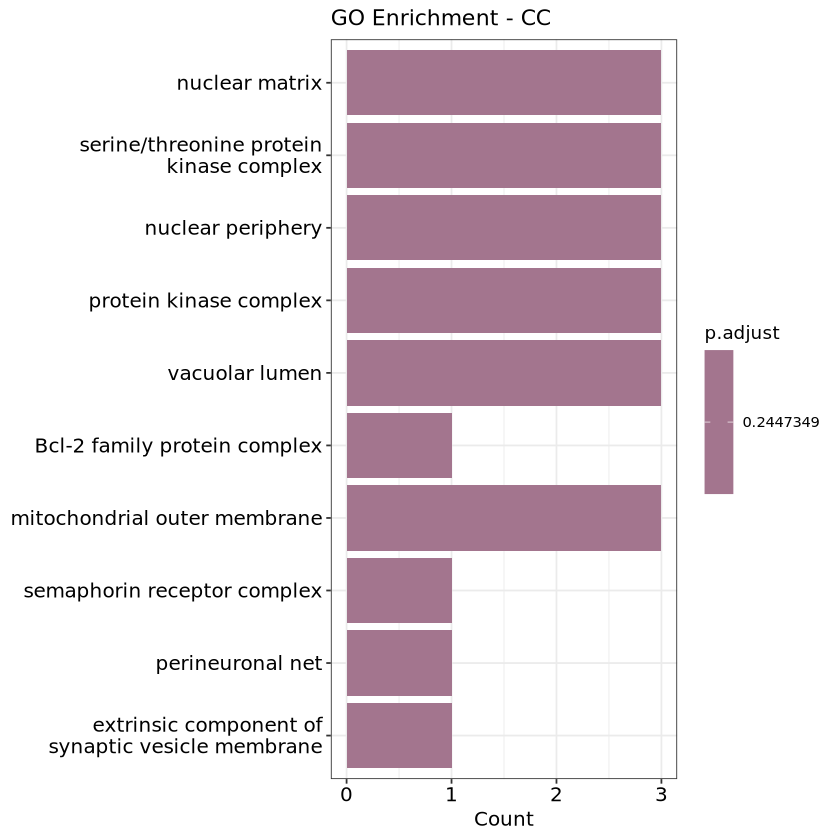

In [56]:
barplot(Aging2_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [57]:
image_Aging2_sig_gene_ego_mf <- enrichGO(
  gene          = unique(image_Aging2_gene$molecular_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [58]:
head(image_Aging2_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0051537,GO:0051537,"2 iron, 2 sulfur cluster binding",2/64,26/21059,0.002819155,0.1890788,0.1501942,ENSG00000183336/ENSG00000145354,2
GO:0004722,GO:0004722,protein serine/threonine phosphatase activity,3/64,108/21059,0.004355169,0.1890788,0.1501942,ENSG00000108389/ENSG00000141298/ENSG00000175175,3
GO:0008170,GO:0008170,N-methyltransferase activity,3/64,109/21059,0.004468812,0.1890788,0.1501942,ENSG00000203791/ENSG00000066651/ENSG00000145002,3
GO:0042578,GO:0042578,phosphoric ester hydrolase activity,5/64,390/21059,0.006619885,0.1890788,0.1501942,ENSG00000108389/ENSG00000102886/ENSG00000141298/ENSG00000175175/ENSG00000124181,5
GO:0140828,GO:0140828,metal cation:monoatomic cation antiporter activity,2/64,43/21059,0.007577319,0.1890788,0.1501942,ENSG00000144290/ENSG00000164037,2
GO:0005539,GO:0005539,glycosaminoglycan binding,4/64,273/21059,0.009550584,0.1890788,0.1501942,ENSG00000110492/ENSG00000135677/ENSG00000038427/ENSG00000146374,4
GO:0015297,GO:0015297,antiporter activity,3/64,150/21059,0.010747807,0.1890788,0.1501942,ENSG00000116704/ENSG00000144290/ENSG00000164037,3
GO:0050661,GO:0050661,NADP binding,2/64,53/21059,0.011340355,0.1890788,0.1501942,ENSG00000089250/ENSG00000049239,2
GO:0016504,GO:0016504,peptidase activator activity,2/64,56/21059,0.012599887,0.1890788,0.1501942,ENSG00000103490/ENSG00000136560,2


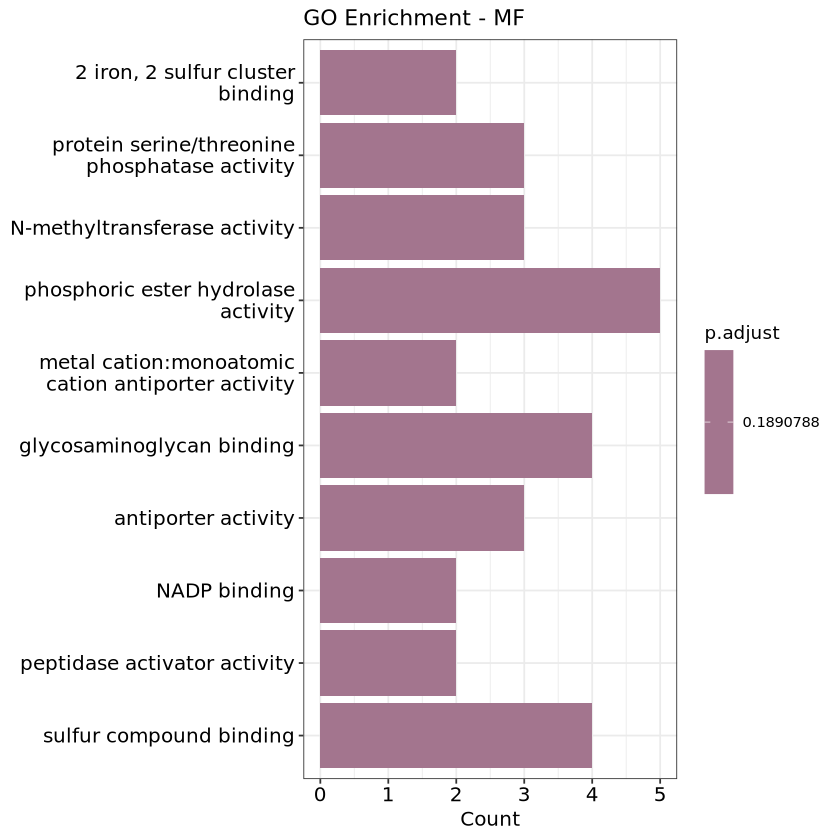

In [59]:
barplot(image_Aging2_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [60]:
entrez_ids <- bitr(image_Aging2_gene$molecular_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(image_Aging2_gene$molecular_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“2.86% of input gene IDs are fail to map...”


In [61]:
kegg_enrich %>% head(n=25)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa05417,Human Diseases,Cardiovascular disease,hsa05417,Lipid and atherosclerosis,6/29,216/9446,4.079503e-05,0.007220721,0.004723635,5595/29108/598/5335/10010/4790,6
hsa05131,Human Diseases,Infectious disease: bacterial,hsa05131,Shigellosis,6/29,253/9446,9.843287e-05,0.008711309,0.005698745,5595/29108/598/5335/4790/10318,6
hsa04621,Organismal Systems,Immune system,hsa04621,NOD-like receptor signaling pathway,5/29,189/9446,2.444135e-04,0.009786558,0.006402149,5595/29108/598/10010/4790,5
hsa04064,Environmental Information Processing,Signal transduction,hsa04064,NF-kappa B signaling pathway,4/29,105/9446,2.764564e-04,0.009786558,0.006402149,9020/598/5335/4790,4
hsa04625,Organismal Systems,Immune system,hsa04625,C-type lectin receptor signaling pathway,4/29,105/9446,2.764564e-04,0.009786558,0.006402149,5595/29108/9020/4790,4
hsa04660,Organismal Systems,Immune system,hsa04660,T cell receptor signaling pathway,4/29,122/9446,4.899947e-04,0.013526071,0.008848456,5595/9020/5335/4790,4
hsa05166,Human Diseases,Infectious disease: viral,hsa05166,Human T-cell leukemia virus 1 infection,5/29,224/9446,5.349294e-04,0.013526071,0.008848456,5595/1031/9020/598/4790,5
hsa04210,Cellular Processes,Cell growth and death,hsa04210,Apoptosis,4/29,137/9446,7.589446e-04,0.015338921,0.010034382,5595/9020/598/4790,4
hsa05135,Human Diseases,Infectious disease: bacterial,hsa05135,Yersinia infection,4/29,138/9446,7.799451e-04,0.015338921,0.010034382,5595/29108/5335/4790,4


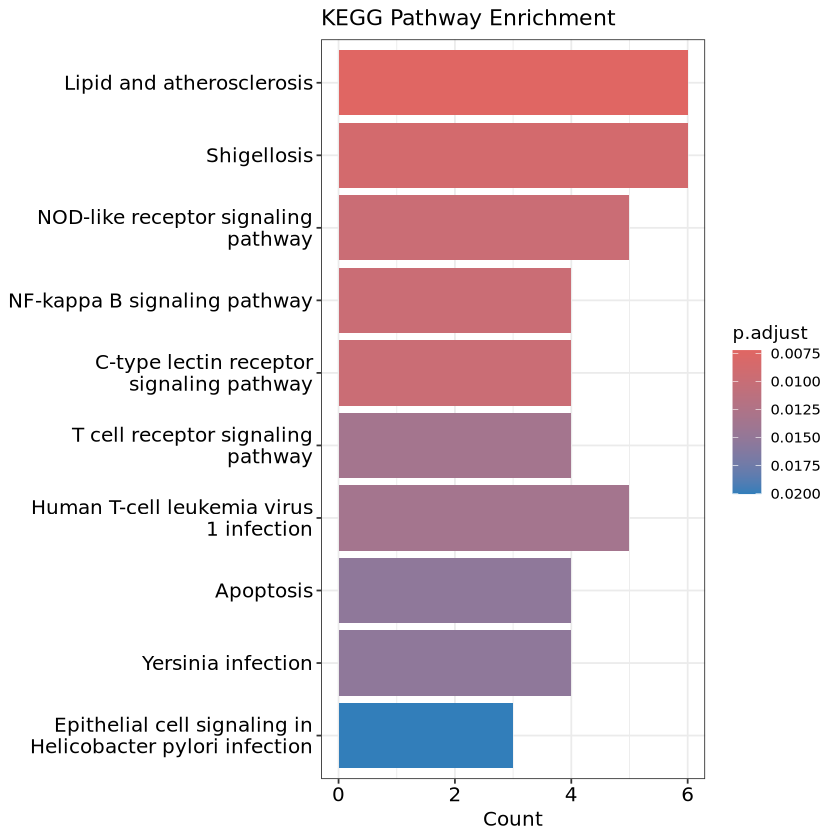

In [62]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")